In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import sys
import copy 
import pickle

import numpy as np 
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm

from scipy import interpolate
from scipy.stats import binned_statistic_2d
from scipy.ndimage.filters import gaussian_filter
from astropy.table import Table, Column, vstack, join

import palettable

cmap_1 = palettable.colorbrewer.sequential.Blues_7_r
cmap_2 = palettable.colorbrewer.sequential.OrRd_7_r
cmap_3 = palettable.colorbrewer.sequential.YlGn_7_r
cmap_4 = palettable.colorbrewer.sequential.Purples_7_r

cmap_list = [cmap_1, cmap_2, cmap_3, cmap_4]

color_bins = ["#377eb8", "#e41a1c", "#1b9e77", "#984ea3"]

In [2]:
import jianbing

from jianbing import hsc
from jianbing import utils
from jianbing import visual
from jianbing import catalog

In [3]:
data_dir = jianbing.DATA_DIR

fig_dir = jianbing.FIG_DIR

sim_dir = jianbing.SIM_DIR
bin_dir = jianbing.BIN_DIR
res_dir = jianbing.RES_DIR

## Discussion about the outer envelope stellar mass as halo mass tracer

In [4]:
from sklearn.linear_model import LinearRegression

from ltsfit import lts_linefit

In [136]:
# Pre-compute
hsc_pre = Table.read(os.path.join(data_dir, 's16a_massive_logm_11.2.fits'))

mask = (
    (hsc_pre['logm_10_100'] >= 9.5) & (hsc_pre['logm_max'] >= 11.2) & 
    (hsc_pre['logm_50_100'] >= 9.5) & (hsc_pre['bsm_s18a'])
)

data_use = hsc_pre[mask]

#### ASAP Mvir v.s. M*[10, 100]

[0.34877889] 6.651474807153572


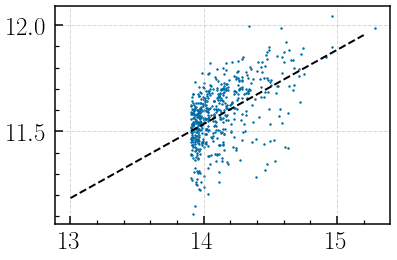

In [125]:
data_use[data_use['logm_cmod_err'] <= 0.02] = 0.02

mask = data_use['logmh_vir_plane'] >= 13.9

x_err = np.full(len(data_use[mask]), 0.02)
y_err = np.hypot(data_use[mask]['logm_cmod_err'], 0.02)

w = 1. / (y_err ** 2.)

x_arr, y_arr = data_use[mask]['logmh_vir_plane'], data_use[mask]['logm_10_100']

reg = LinearRegression().fit(x_arr.reshape(-1, 1), y_arr, sample_weight=w)

print(reg.coef_, reg.intercept_)

plt.scatter(x_arr, y_arr, s=2)

x_grid = np.linspace(13.0, 15.2, 100)
plt.plot(x_grid, reg.coef_ * x_grid + reg.intercept_, linewidth=2.0, linestyle='--', c='k')

In [126]:
x_mask = x_arr >= 13.9

np.nanstd(y_arr[x_mask] - (reg.coef_ * x_arr[x_mask] + reg.intercept_))

0.12158404291381113

sig_int:     0.0000      5.8049
Computing sig_int
sig_int:     0.0000      5.8049
sig_int:     0.1308     -0.2353
sig_int:     0.1257     -0.1800
sig_int:     0.1096      0.0375
sig_int:     0.1123     -0.0054
sig_int:     0.1120     -0.0001
sig_int:     0.1119      0.0007
Computing sig_int error
sig_int:     0.1120      0.0615
sig_int:     0.1308     -0.1737
sig_int:     0.1169     -0.0090
sig_int:     0.1163     -0.0004
sig_int:     0.1162      0.0004
Repeat at best fitting solution
sig_int:     0.1120     -0.0001
################# Values and formal errors ################
 intercept:  11.5578 +/- 0.0056
     slope:  0.359 +/- 0.025
   scatter:  0.1120 +/- 0.0043
Observed rms scatter: 0.12
y = a + b*(x - pivot) with pivot = 14.06
Spearman r=0.51 and p=5.9e-37
Pearson r=0.53 and p=6.9e-40
##########################################################
seconds 25.52


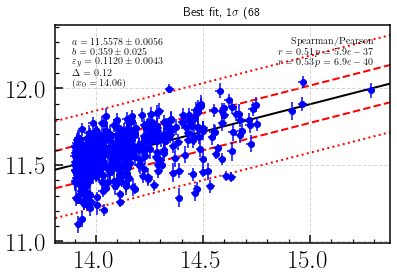

In [127]:
lts_linefit.lts_linefit(
    x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=4.0
)

#### ASAP Mvir v.s. M*[50, 100]

[0.4642407] 4.396438045107332


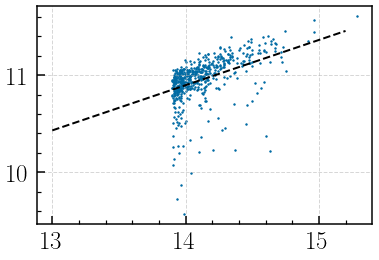

In [122]:
data_use[data_use['logm_cmod_err'] <= 0.02] = 0.02

mask = data_use['logmh_vir_plane'] >= 13.9

x_err = np.full(len(data_use[mask]), 0.02)
y_err = np.hypot(data_use[mask]['logm_cmod_err'], 0.02)

w = 1. / (y_err ** 2.)

x_arr, y_arr = data_use[mask]['logmh_vir_plane'], data_use[mask]['logm_50_100']

reg = LinearRegression().fit(
    x_arr[y_arr >= 10.2].reshape(-1, 1), y_arr[y_arr >= 10.2], 
    sample_weight=w[y_arr >= 10.2])

print(reg.coef_, reg.intercept_)

plt.scatter(x_arr, y_arr, s=2)

x_grid = np.linspace(13.0, 15.2, 100)
plt.plot(x_grid, reg.coef_ * x_grid + reg.intercept_, linewidth=2.0, linestyle='--', c='k')

In [123]:
x_mask = x_arr >= 14.0

np.nanstd(y_arr[x_mask] - (reg.coef_ * x_arr[x_mask] + reg.intercept_))

0.1886478769376214

sig_int:     0.0000      2.4664
Computing sig_int
sig_int:     0.0000      2.4664
sig_int:     0.1016     -0.3207
sig_int:     0.0899     -0.1904
sig_int:     0.0740      0.0738
sig_int:     0.0785     -0.0103
sig_int:     0.0779     -0.0005
sig_int:     0.0779      0.0002
Computing sig_int error
sig_int:     0.0779      0.0653
sig_int:     0.1016     -0.2557
sig_int:     0.0827     -0.0178
sig_int:     0.0817     -0.0008
sig_int:     0.0816      0.0000
Repeat at best fitting solution
sig_int:     0.0779      0.0002
################# Values and formal errors ################
 intercept:  10.9768 +/- 0.0045
     slope:  0.561 +/- 0.020
   scatter:  0.0779 +/- 0.0037
Observed rms scatter: 0.093
y = a + b*(x - pivot) with pivot = 14.06
Spearman r=0.61 and p=1.4e-55
Pearson r=0.49 and p=1.2e-33
##########################################################
seconds 27.57


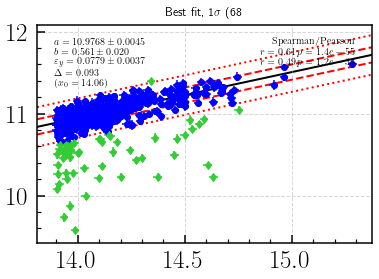

In [124]:
lts_linefit.lts_linefit(
    x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=3.0
)

#### ASAP Mvir v.s. M*100

[0.3429408] 6.913537453811519


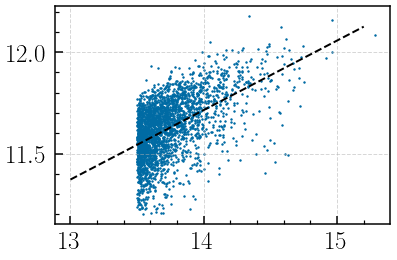

In [75]:
data_use[data_use['logm_cmod_err'] <= 0.02] = 0.02

mask = data_use['logmh_vir_plane'] >= 13.5

x_err = np.full(len(data_use[mask]), 0.02)
y_err = np.hypot(data_use[mask]['logm_cmod_err'], 0.02)

w = 1. / (y_err ** 2.)

x_arr, y_arr = data_use[mask]['logmh_vir_plane'], data_use[mask]['logm_100']

reg = LinearRegression().fit(
    x_arr[y_arr >= 10.2].reshape(-1, 1), y_arr[y_arr >= 10.2], 
    sample_weight=w[y_arr >= 10.2])

print(reg.coef_, reg.intercept_)

plt.scatter(x_arr, y_arr, s=2)

x_grid = np.linspace(13.0, 15.2, 100)
plt.plot(x_grid, reg.coef_ * x_grid + reg.intercept_, linewidth=2.0, linestyle='--', c='k')

In [77]:
x_mask = x_arr >= 14.0

np.nanstd(y_arr[x_mask] - (reg.coef_ * x_arr[x_mask] + reg.intercept_))

0.14135552604720503

sig_int:     0.0000      6.3580
Computing sig_int
sig_int:     0.0000      6.3580
sig_int:     0.1290     -0.1737
sig_int:     0.1256     -0.1338
sig_int:     0.1143      0.0185
sig_int:     0.1157     -0.0019
sig_int:     0.1156     -0.0000
sig_int:     0.1155      0.0008
Computing sig_int error
sig_int:     0.1156      0.0270
sig_int:     0.1290     -0.1467
sig_int:     0.1177     -0.0032
sig_int:     0.1174     -0.0001
sig_int:     0.1174      0.0008
Repeat at best fitting solution
sig_int:     0.1156     -0.0000
################# Values and formal errors ################
 intercept:  11.6058 +/- 0.0025
     slope:  0.344 +/- 0.010
   scatter:  0.1156 +/- 0.0019
Observed rms scatter: 0.13
y = a + b*(x - pivot) with pivot = 13.67
Spearman r=0.51 and p=7.8e-185
Pearson r=0.53 and p=3.4e-202
##########################################################
seconds 32.37


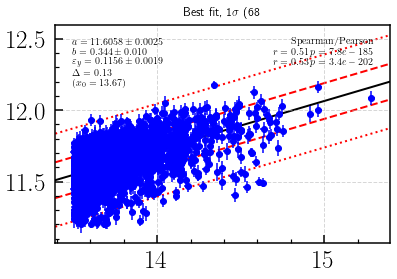

In [78]:
lts_linefit.lts_linefit(
    x_arr, y_arr, x_err, y_err, pivot=np.nanmedian(x_arr), clip=4.0
)

#### Making the plot for the paper

Text(0, 0.5, '$\\log (M_{\\star, [50, 100]}/ M_{\\odot})$')

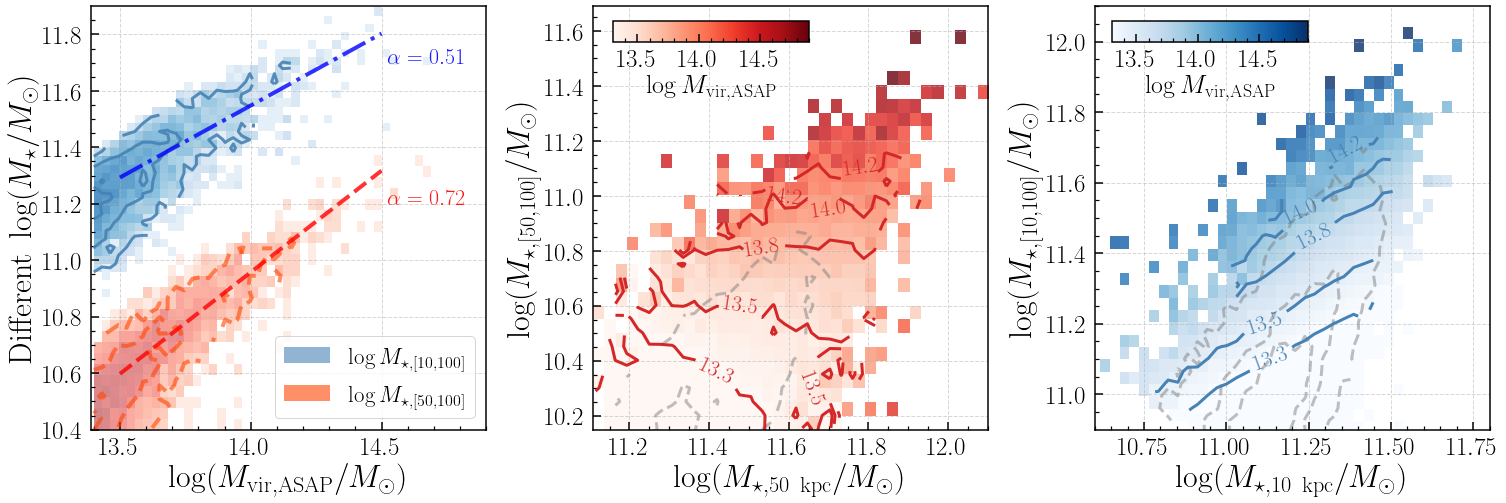

In [183]:
fig = plt.figure(figsize=(21, 7))
fig.subplots_adjust(
    left=0.065, bottom=0.15, right=0.99, top=0.99, wspace=0.27, hspace=None)

ax1 = fig.add_subplot(131)

x_mask = data_use['logmh_vir_plane'] >= 13.4

# Tracer 1
z_stats_1, x_edges_1, y_edges_1, binnum_1 = binned_statistic_2d(
    data_use['logmh_vir_plane'][x_mask], data_use['logm_10_100'][x_mask], 
    data_use['logm_10_100'][x_mask], 
    'count', bins=[60, 40])
z_stats_1[z_stats_1 < 2] = np.nan

# Tracer 2
z_stats_2, x_edges_2, y_edges_2, binnum_2 = binned_statistic_2d(
    data_use['logmh_vir_plane'][x_mask], data_use['logm_50_100'][x_mask], 
    data_use['logm_10_100'][x_mask], 
    'count', bins=[60, 54])
z_stats_2[z_stats_2 < 2] = np.nan

HM_1 = ax1.imshow(
    z_stats_1.T, origin='lower', cmap='Blues', norm=LogNorm(vmin=1, vmax=300),
    extent=[x_edges_1[0], x_edges_1[-1], y_edges_1[0], y_edges_1[-1]],
    aspect='auto', interpolation='nearest', alpha=0.8)

HM_2 = ax1.imshow(
    z_stats_2.T, origin='lower', cmap='Reds', norm=LogNorm(vmin=1, vmax=100),
    extent=[x_edges_2[0], x_edges_2[-1], y_edges_2[0], y_edges_2[-1]],
    aspect='auto', interpolation='nearest', alpha=0.5)

CT_1 = ax1.contour(
    x_edges_1[:-1], y_edges_1[:-1], gaussian_filter(z_stats_1.T, 0.12),
    5, linewidths=3.0, linestyles='solid', colors='steelblue', alpha=0.9, 
    levels=[5, 20, 50], extend='neither')

CT_2 = ax1.contour(
    x_edges_2[:-1], y_edges_2[:-1], gaussian_filter(z_stats_2.T, 0.12),
    5, linewidths=4.0, linestyles='dashed', colors='orangered', alpha=0.6, 
    levels=[5, 20, 50], extend='neither')

x_grid = np.linspace(13.5, 14.5, 10)
ax1.plot(x_grid, 10.72 + 0.72 * (x_grid - 13.67), linestyle='--', linewidth=4, c='r', alpha=0.8)
#ax1.plot(x_grid, 10.98 + 0.56 * (x_grid - 14.06), linestyle='--', linewidth=4, c='r', alpha=0.8)
ax1.text(14.52, 11.2, r'$\alpha=0.72$', fontsize=22, color='red', alpha=0.9)

ax1.plot(x_grid, 11.38 + 0.51 * (x_grid - 13.67), linestyle='-.', linewidth=4, c='b', alpha=0.8)
#ax1.plot(x_grid, 11.56 + 0.36 * (x_grid - 14.06), linestyle='-.', linewidth=4, c='b', alpha=0.8)
ax1.text(14.52, 11.7, r'$\alpha=0.51$', fontsize=22, color='blue', alpha=0.9)

proxy = [plt.Rectangle((0, 0), 0.5, 0.5, fc=c, alpha=0.6) for c in ['steelblue', 'orangered']]
ax1.legend(proxy, [r'$\log M_{\star, [10, 100]}$', r'$\log  M_{\star, [50, 100]}$'],
           loc="lower right", fontsize=23)

ax1.set_xlim(13.39, 14.9)
ax1.set_ylim(10.40, 11.9)
ax1.set_xlabel(r'$\log (M_{\rm vir, ASAP}/ M_{\odot})$', fontsize=32)
ax1.set_ylabel(r'${\rm Different\ } \log (M_{\star}/M_{\odot})$', fontsize=32)

ax2 = fig.add_subplot(133)

z_stats_3, x_edges_3, y_edges_3, binnum_3 = binned_statistic_2d(
    data_use['logm_10'], data_use['logm_10_100'], data_use['logmh_vir_plane'], 
    np.nanmean, bins=[40, 50])
z_count_3, _, _, _ = binned_statistic_2d(
    data_use['logm_10'], data_use['logm_10_100'], data_use['logmh_vir_plane'], 
    'count', bins=[40, 50])
z_stats_3[z_stats_3 < 2] = np.nan
z_count_3[z_count_3 < 2] = np.nan

HM_3 = ax2.imshow(
    z_stats_3.T, origin='lower', cmap='Blues', vmin=13.3, vmax=14.9,
    extent=[x_edges_3[0], x_edges_3[-1], y_edges_3[0], y_edges_3[-1]],
    aspect='auto', interpolation='nearest', alpha=0.8)

CT_3 = ax2.contour(
    x_edges_3[:-1], y_edges_3[:-1], gaussian_filter(z_count_3.T, 0.1),
    5, linewidths=3.0, linestyles='dashed', colors='grey', alpha=0.5, 
    levels=[8, 50, 100], extend='neither')

CT_3b = ax2.contour(
    x_edges_3[:-1], y_edges_3[:-1], gaussian_filter(z_stats_3.T, 0.2),
    4, linewidths=3.0, alpha=1.0, colors='steelblue',
    levels=[13.3, 13.5, 13.8, 14.0, 14.2], extend='neither')
_ = ax2.clabel(CT_3b, inline=1, fontsize=22, colors='steelblue', fmt=r'$%4.1f$')

ax2.set_xlim(10.6, 11.8)
ax2.set_ylim(10.9, 12.1)
ax2.set_xlabel(r'$\log (M_{\star, 10\ \rm kpc}/ M_{\odot})$', fontsize=32)
ax2.set_ylabel(r'$\log (M_{\star, [10, 100]}/ M_{\odot})$', fontsize=32)

cax_3 = fig.add_axes([0.74, 0.92, 0.13, 0.04])
cbar_3 = plt.colorbar(HM_3, cax=cax_3, orientation='horizontal')
cbar_3.solids.set_edgecolor("face")
cax_3.set_xlabel(r'$\log M_{\rm vir, ASAP}$', fontsize=26)

ax3 = fig.add_subplot(132)

z_stats_4, x_edges_4, y_edges_4, binnum_4 = binned_statistic_2d(
    data_use['logm_50'], data_use['logm_50_100'], data_use['logmh_vir_plane'], 
    np.nanmean, bins=[35, 42])
z_count_4, _, _, _ = binned_statistic_2d(
    data_use['logm_50'], data_use['logm_50_100'], data_use['logmh_vir_plane'], 
    'count', bins=[35, 42])
z_stats_4[z_stats_4 < 5] = np.nan
z_count_4[z_count_4 < 5] = np.nan

HM_4 = ax3.imshow(
    z_stats_4.T, origin='lower', cmap='Reds', vmin=13.3, vmax=14.9,
    extent=[x_edges_4[0], x_edges_4[-1], y_edges_4[0], y_edges_4[-1]],
    aspect='auto', interpolation='nearest', alpha=0.8)

CT_4 = ax3.contour(
    x_edges_4[:-1], y_edges_4[:-1], gaussian_filter(z_count_4.T, 0.15),
    5, linewidths=3.0, linestyles='dashed', colors='grey', alpha=0.5, 
    levels=[20, 100, 250], extend='neither')

CT_4b = ax3.contour(
    x_edges_4[:-1], y_edges_4[:-1], gaussian_filter(z_stats_4.T, 0.12),
    4, linewidths=3.0, alpha=1.0, colors='tab:red',
    levels=[13.3, 13.5, 13.8, 14.0, 14.2], extend='neither')
_ = ax3.clabel(CT_4b, inline=1, fontsize=22, colors='tab:red', fmt=r'$%4.1f$')
    
cax_4 = fig.add_axes([0.41, 0.92, 0.13, 0.04])
cbar_4 = plt.colorbar(HM_4, cax=cax_4, orientation='horizontal')
cbar_4.solids.set_edgecolor("face")
cax_4.set_xlabel(r'$\log M_{\rm vir, ASAP}$', fontsize=26)

ax3.set_ylim(10.15, 11.69)
ax3.set_xlabel(r'$\log (M_{\star, 50\ \rm kpc}/ M_{\odot})$', fontsize=32)
ax3.set_ylabel(r'$\log (M_{\star, [50, 100]}/ M_{\odot})$', fontsize=32)

In [22]:
fig.savefig(os.path.join(fig_dir, 'fig_12.png'), dpi=120)
fig.savefig(os.path.join(fig_dir, 'fig_12.pdf'), dpi=120)